In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from bd_datagen import generate_collocation_points
from bd_ffe import FourierFeatureEmbedding
from bd_physicsandloss_fns import pde_loss, bc_loss, interface_loss, flexural_rigidity, normalise, denormalise
from bd_beamnet import BeamNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


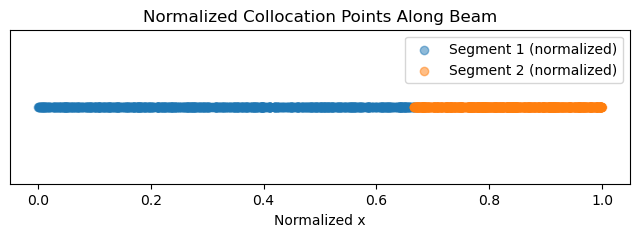

In [2]:
# data generation

n_collocation = 1000
x_ranges = [(0,2), (2,3)]

x1,x2 = generate_collocation_points(n_collocation, x_ranges)
x_min, x_max = 0.0, 3.0
x1 = normalise(x1, x_min, x_max)
x2 = normalise(x2, x_min, x_max)
x1_torch = torch.from_numpy(x1).to(torch.float32).to(device).requires_grad_(True)
x2_torch = torch.from_numpy(x2).to(torch.float32).to(device).requires_grad_(True)

#print(x1_torch, x2_torch)


# Flatten the arrays for plotting
x1_flat = x1.flatten()
x2_flat = x2.flatten()

plt.figure(figsize=(8, 2))
plt.scatter(x1_flat, np.zeros_like(x1_flat), alpha=0.5, label='Segment 1 (normalized)')
plt.scatter(x2_flat, np.zeros_like(x2_flat), alpha=0.5, label='Segment 2 (normalized)')
plt.xlabel('Normalized x')
plt.yticks([])
plt.title('Normalized Collocation Points Along Beam')
plt.legend()
plt.show()


Epoch 0: Total Loss 3.5753e+07 | PDE 5.2261e+06 | BC 7.3811e+06 | IF 2.3146e+07
Epoch 100: Total Loss 1.0081e+03 | PDE 8.7462e+02 | BC 5.9841e+01 | IF 7.3614e+01
Epoch 200: Total Loss 5.6597e+02 | PDE 5.6572e+02 | BC 8.8251e-04 | IF 2.4369e-01
Epoch 300: Total Loss 3.5938e+02 | PDE 3.5926e+02 | BC 4.1073e-04 | IF 1.2096e-01
Epoch 400: Total Loss 2.1006e+02 | PDE 2.1000e+02 | BC 2.5805e-04 | IF 6.1557e-02
Epoch 500: Total Loss 1.1414e+02 | PDE 1.1411e+02 | BC 1.7496e-04 | IF 3.0055e-02
Epoch 600: Total Loss 5.8799e+01 | PDE 5.8785e+01 | BC 1.1813e-04 | IF 1.4445e-02
Epoch 700: Total Loss 3.0134e+01 | PDE 3.0127e+01 | BC 8.9263e-05 | IF 7.0740e-03
Epoch 800: Total Loss 1.6742e+01 | PDE 1.6739e+01 | BC 7.5410e-05 | IF 3.3406e-03
Epoch 900: Total Loss 1.0969e+01 | PDE 1.0967e+01 | BC 6.8994e-05 | IF 1.9386e-03


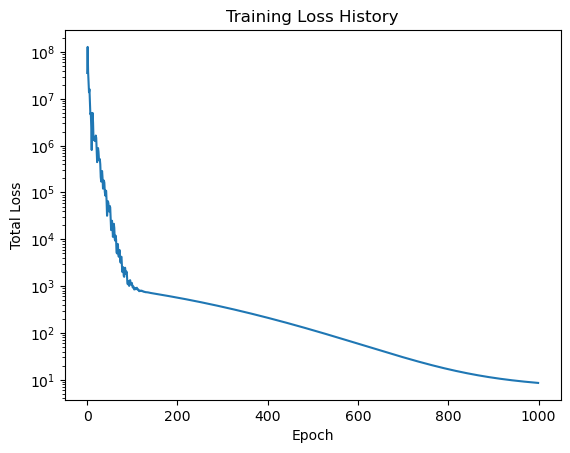

In [3]:
#instantiate the model and plot the losses wrt epochs

model =  BeamNet(input_dim=1, output_dim=2,
                 n_units=40, n_layers=4,
                 pde_weight=1.0, bc_weight=1.0, if_weight=1.0,
                 use_ffe=False, num_frequencies=4, fourier_scale=1.0).to(device)

losses = model.fit(x1_torch, x2_torch, xmin=0.0, xmax=3.0, epochs=1000, lr=0.01)



plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History')
plt.show()

torch.Size([500, 1])
x_norm shape: (500,)
w_true shape: (500,)
pinn_output shape: (500, 2)
w_pinn shape: (500,)


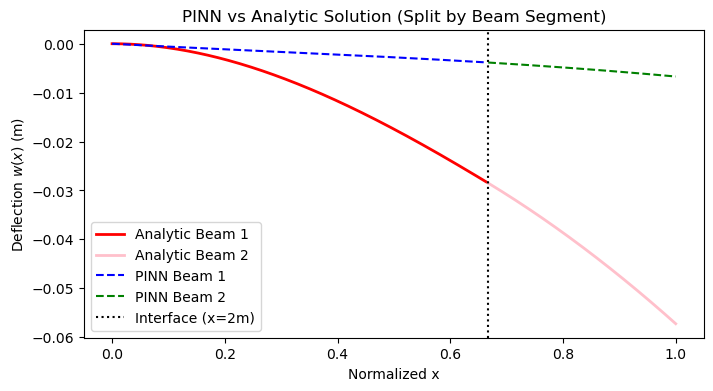

w_at_2m: -0.028455893317255693, w_at_3m: -0.057264201151357726


In [4]:
# Generate a dense set of normalized x values
#x_plot = np.linspace(0, 1, 500).reshape(-1, 1).astype(np.float32)
##x_plot_torch = torch.from_numpy(x_plot).to(torch.float32).to(device)

# Get model predictions
#model.eval()
#with torch.no_grad():
#    w_pred = model(x_plot_torch).cpu().numpy().flatten()


#=======================================================================================
# Copy and pasted from chatgpt
#==========================================================================================

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Beam and material properties
E1, D1 = 210e9, 0.05
E2, D2 = 180e9, 0.04
I1 = np.pi/64 * D1**4
I2 = np.pi/64 * D2**4
EI1 = E1 * I1
EI2 = E2 * I2

# 2. Solve for analytic solution coefficients
A = np.zeros((5, 5))
b = np.zeros(5)

# Unknowns: [c1, d1, a2, b2, c2]
A[0, 0] = 4      # c1
A[0, 1] = 8      # d1
A[0, 2] = -1     # a2
A[0, 3] = -2     # b2
A[0, 4] = -4     # c2
b[0] = 0

A[1, 0] = 4      # c1
A[1, 1] = 12     # d1
A[1, 3] = -1     # b2
A[1, 4] = -4     # c2
b[1] = 0

A[2, 0] = 2*EI1
A[2, 1] = 12*EI1
A[2, 4] = -2*EI2
b[2] = 0

A[3, 1] = -6*EI1
b[3] = -500

A[4, 4] = 2*EI2
b[4] = -250

sol = np.linalg.solve(A, b)
c1, d1, a2, b2, c2 = sol

def w_analytic(x):
    w = np.zeros_like(x)
    mask1 = x < 2
    mask2 = x >= 2
    w[mask1] = c1 * x[mask1]**2 + d1 * x[mask1]**3
    w[mask2] = a2 + b2 * x[mask2] + c2 * x[mask2]**2
    return w

# Generate x values and normalize
x_min, x_max = 0.0, 3.0
x_phys = np.linspace(0, 3, 500)
x_norm = (x_phys - x_min) / (x_max - x_min)

# Evaluate analytic solution
w_true = w_analytic(x_phys)

# Evaluate PINN prediction on the SAME x_norm points
x_norm_torch = torch.from_numpy(x_norm.reshape(-1, 1)).to(torch.float32).to(next(model.parameters()).device)
print(x_norm_torch.shape)
model.eval()
with torch.no_grad():
    pinn_output = model(x_norm_torch).cpu().numpy()
    w_pinn = pinn_output[:, 0]

# Define the interface in normalized coordinates
interface_phys = 2.0
interface_norm = (interface_phys - x_min) / (x_max - x_min)

# Create masks for each segment
mask1 = x_norm < interface_norm
mask2 = x_norm >= interface_norm

print("x_norm shape:", x_norm.shape)
print("w_true shape:", w_true.shape)
print("pinn_output shape:", pinn_output.shape)
print("w_pinn shape:", w_pinn.shape)



# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_norm[mask1], w_true[mask1], color='r', linewidth=2, label='Analytic Beam 1')
plt.plot(x_norm[mask2], w_true[mask2], color='pink', linewidth=2, label='Analytic Beam 2')
plt.plot(x_norm[mask1], w_pinn[mask1], '--', color='b', label='PINN Beam 1')
plt.plot(x_norm[mask2], w_pinn[mask2], '--', color='g', label='PINN Beam 2')
plt.axvline(interface_norm, color='k', linestyle=':', label='Interface (x=2m)')
plt.xlabel('Normalized x')
plt.ylabel('Deflection $w(x)$ (m)')
plt.title('PINN vs Analytic Solution (Split by Beam Segment)')
plt.legend()
plt.show()

# Define the physical x values to evaluate
x_at_2m = 2.0
x_at_3m = 3.0

# Evaluate the analytic solution at these specific x values
# Pass them as a NumPy array to match the w_analytic function's expected input
w_at_2m = w_analytic(np.array([x_at_2m]))[0] # [0] to get the scalar value from the array
w_at_3m = w_analytic(np.array([x_at_3m]))[0]

print(f"w_at_2m: {w_at_2m}, w_at_3m: {w_at_3m}")

#================================================================================
#================================================================================

##plt.figure(figsize=(8, 4))
#plt.plot(x_plot, w_pred, label='Predicted $w(x)$')
#plt.xlabel('Normalized x')
#plt.ylabel('Deflection $w(x)$')
#plt.title('PINN Predicted Beam Deflection')
#plt.legend()
#plt.show()